<a href="https://colab.research.google.com/github/JasonChuang88/SVR/blob/main/predict_ATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
# hide code cell output
from google.colab import drive
drive.mount('/content/drive')

In [97]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as py
import scipy.stats as stats
from sklearn import metrics, model_selection, preprocessing, svm
from typing import Union, Optional
sc = preprocessing.StandardScaler()

In [162]:
def normal_split(df: Union[pd.DataFrame, pd.Series], split: float = 0.8, features: int = 1, is_dummy: bool = False):
    nd = df.to_numpy()
    train_set, test_set = np.split(nd, [int(split * len(nd))])
    train_set = train_set.reshape(-1, features)
    test_set = test_set.reshape(-1, features)
    if not is_dummy:
        train_set = sc.fit_transform(train_set)
        test_set = sc.transform(test_set)
    return train_set, test_set

In [175]:
def handle_datasets(file_name: str, train_split: float = 0.8) -> list[np.ndarray]:
    df = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/{file_name}.csv')
    # drop row if created_at>ATD
    df = df.drop(df[(df['created_at'] > df['ATD'])].index)
    df = df.dropna(subset=['ETA','ETD','ATA','ATD','is_rail'])
    df = df.drop(columns=['scac_code','firms_code'])
    # handle nominal
    dummy = df.drop(columns=['ATA','ATD','ETA','ETD','created_at'])
    dummy = pd.get_dummies(dummy)
    dummy_train, dummy_test = normal_split(dummy, split = train_split,features = dummy.shape[1], is_dummy=True)
    # exclude 3 columns, others = input features
    x = df[df.columns.difference(['ATA','is_rail','POD','POL','svc_term_from','svc_term_to','ship_mode','vessel_name'])]
    y = df['ATA']
    x_train, x_test = normal_split(x, split = train_split,features = x.shape[1])
    # concatenate dummy variable and numeric variable
    x_train = np.concatenate((dummy_train, x_train), axis=1)
    x_test = np.concatenate((dummy_test, x_test), axis=1)
    y_train, y_test = normal_split(y, split = train_split)
    return [x_train, y_train, x_test, y_test]

In [172]:
def train(datasets: list[np.ndarray], kernel: str = 'rbf') -> None:
    x_train, y_train, x_test, y_test = (
        datasets[0],
        datasets[1],
        datasets[2],
        datasets[3],
    )
    polyModel=svm.SVR(kernel=kernel)
    print(f'SVR kernel: {kernel}')
    polyModel.fit(x_train, y_train.ravel())
    # training
    y_train_pred=polyModel.predict(x_train)
    y_train_pred = sc.inverse_transform(y_train_pred.reshape(-1, 1))
    y_train = sc.inverse_transform(y_train)
    rmse = metrics.mean_squared_error(y_train, y_train_pred, squared=False)
    mae = metrics.mean_absolute_error(y_train, y_train_pred)
    r2 = metrics.r2_score(y_train, y_train_pred)
    print(f'training RMSE: {rmse}, MAE: {mae}, R2 score: {r2}')
    # testing
    y_test_pred=polyModel.predict(x_test)
    y_test_pred = sc.inverse_transform(y_test_pred.reshape(-1, 1))
    y_test = sc.inverse_transform(y_test)
    rmse = metrics.mean_squared_error(y_test, y_test_pred, squared=False)
    mae = metrics.mean_absolute_error(y_test, y_test_pred)
    r2 = metrics.r2_score(y_test, y_test_pred)
    print(f'testing RMSE: {rmse}, MAE: {mae}, R2 score: {r2}')
    residual = y_test - y_test_pred
    plt.clf()
    plt.hist(residual, bins=40, range=(-50,50), facecolor="blue", edgecolor="black", alpha=0.7, density=True)
    plt.xlabel("residual")
    plt.ylabel("Probability")
    plt.show(block=False)

SVR kernel: linear
training RMSE: 2.3243909928047026, MAE: 1.5012607031859715, R2 score: 0.9864428694759504
testing RMSE: 3.671530053956957, MAE: 2.1946463617854897, R2 score: 0.9713478900566662


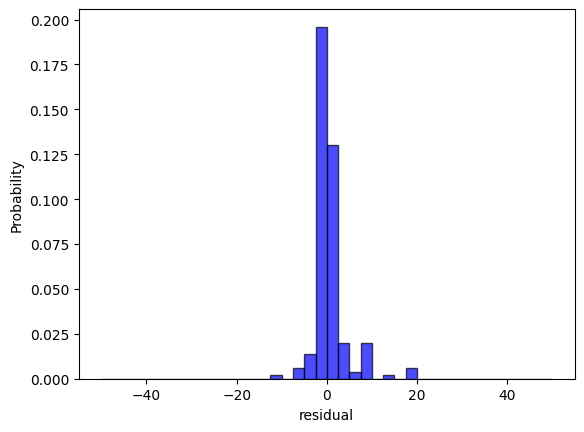

SVR kernel: poly
training RMSE: 2.186832690969937, MAE: 1.5645467580047716, R2 score: 0.9880000199311317
testing RMSE: 10.395146973137173, MAE: 5.650376690609301, R2 score: 0.770319723701947


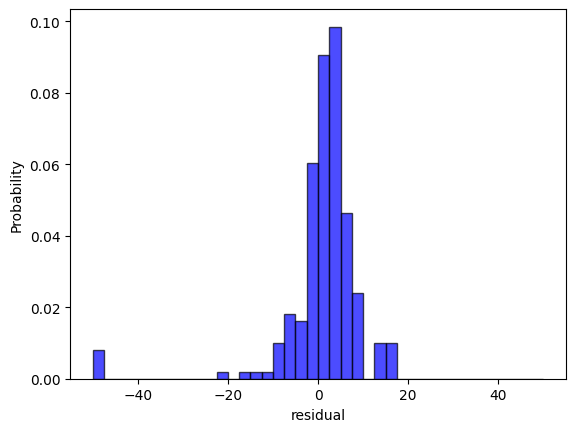

SVR kernel: rbf
training RMSE: 2.2864781396456255, MAE: 1.5016485285804537, R2 score: 0.986881520022193
testing RMSE: 12.271307379128471, MAE: 6.333850365169383, R2 score: 0.6799306386490982


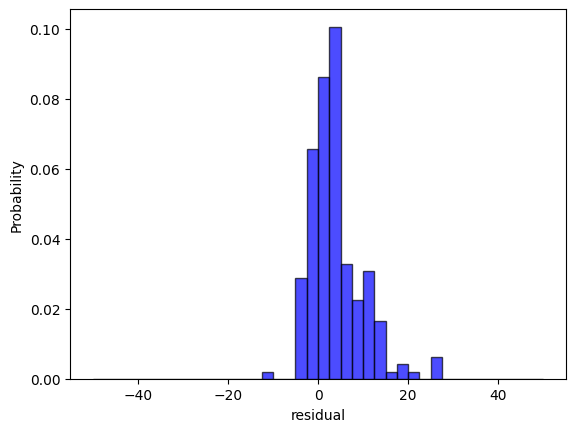

In [176]:
if __name__ == "__main__":
    # options: training_1000, training_10000, CMDU_training_2000
    file_name = "training_1000"
    data = handle_datasets(file_name=file_name,train_split=0.8)
    kernel_list = ['linear', 'poly', 'rbf']
    for kernel in kernel_list:
        train(data, kernel=kernel)